In [1]:
#|default_exp sadspheres
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## project specifics'
import diffusion_curvature

from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
# from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Saddle Sphere Ablations
> Little brother to the Curvature Colosseum

This is a dataset intended to measure the sign discrimination ability of diffusion curvature and other curvature methods. The dataset consists of different samplings of saddles and spheres with varying intensities of curvature and in varying dimensions. There's also the possibility of adding noise. This notebook implements a class which creates this dataset with specified parameters as well as convenience functions which can be used for testing it and visualizing the results.

# Implementation

Because of the specialized purpose of this dataset, we're wrapping it in a special class, which allows the dataset to evaluate its own fidelity in embeddings.

It works like this:
1. Instatiate the class, supply the dimensions, and noise level, and it will create all of the graphs.
2. To run curvature computations on these graphs, you can extract them directly -- or, you can use the dataset as an *iterator*, loop through, run your own logic within, then run an 'update' function to store the result.
3. Afterwards, you can use the built in methods for visualizing and getting metrics on the performance.

In [81]:
#|export
from diffusion_curvature.core import get_adaptive_graph
from diffusion_curvature.datasets import rejection_sample_from_saddle, sphere, plane
from fastcore.all import *
import xarray as xr
import inspect
import pandas as pd

import sklearn
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

def metric(func):
    setattr(func, 'tag', 'metric')
    return func

class SadSpheres():
    def __init__(self,
                 dimension = 2, # Dimension of saddles and spheres
                 num_pointclouds = 100, # num pointclouds to make in total
                 num_points = 2000, # num points per pointclouds
                 noise_level = 0, # from 0 to 1. 1 is all noise.
                 include_planes = False, # if True, includes randomly sampled planes as a sanity check.
                ):
        store_attr()
        self.DS = xr.Dataset()
        self.idx = -1
        self.dnum = 3 if self.include_planes else 2
        for i in range(num_pointclouds//self.dnum):
            X_saddle, ks_saddle = rejection_sample_from_saddle(self.num_points, self.dimension)
            self.DS[self.dnum*i] = xr.DataArray(X_saddle, dims=['n', 'd'], attrs={'ks':ks_saddle, 'name':'Saddle'})
            X_sphere, ks_sphere = sphere(self.num_points, self.dimension)
            self.DS[self.dnum*i+1] = xr.DataArray(X_sphere, dims=['n', 'd'], attrs={'ks':ks_sphere[0], 'name':'Sphere'})
            if self.include_planes:
                X_plane = plane(self.num_points, self.dimension) 
                X_plane = np.hstack([X_plane, np.zeros(self.num_points)[:,None]])
                self.DS[self.dnum*i + 2] = xr.DataArray(X_plane, dims=['n', 'd'], attrs = {'ks':0, 'name':'Plane'})
    
    def __iter__(self):
        return self

    def __len__(self):
        return len(self.DS)

    def __next__(self):
        self.idx += 1
        if self.idx >= self.__len__():
            raise StopIteration
        result = self.DS[self.idx].to_numpy()
        return result

    def update(self,
               result,
               method_name='computed'):
        """
        Store the result of the curvature computation by passing the computed curvature of the center (first) point.
        """
        self.DS[self.idx].attrs[method_name] = result

    def compute_metrics(self):
        self._aggregate_labels()
        metrics = self._get_metrics()
        self.metric_table = {}
        for metric in metrics:
            self.metric_table[metric.__name__] = {}
            for method_name in self.method_names:
                self.metric_table[metric.__name__][method_name] = self.compute(metric=metric, method_name=method_name)
        self.metric_table = pd.DataFrame(self.metric_table)
            
    def compute(self, metric, method_name):
        # Overwrite this class with your logic. It implements the computation of a single metric for a single method
        return metric(self.labels[method_name], self.labels['ks'])
    

    def _aggregate_labels(self):
        self.method_names = list(self.DS.data_vars[0].attrs.keys())
        self.method_names.remove('name')
        self.labels = {}
        for m in self.method_names:
            self.labels[m] = np.array([self.DS.data_vars[i].attrs[m] for i in range(self.__len__())])

    def plot(self, title = ""):
        # for each computed method on this dataset, we plot the histogram of saddles vs spheres
        self._aggregate_labels()
        # get the idxs for each type of dataset
        dataset_names = [self.DS.data_vars[i].attrs['name'] for i in range(len(self.DS))]
        unique_names = list(set(dataset_names))
        idxs_by_name = {n: [i for i, name in enumerate(dataset_names) if name == n] for n in unique_names}        
        for m in self.method_names: 
            if m != 'ks' and m != 'name':
                for dname in unique_names:
                    plt.hist(self.labels[m][idxs_by_name[dname]], bins=50, label = dname, edgecolor='none', linewidth=5)
                plt.legend()
                plt.xlabel(m)
                plt.title(f"In dimension {self.dimension}")
                plt.show()

    def table(self):
        self.compute_metrics()
        return self.metric_table

    def _get_metrics(self):
        tagged_functions = []
        for name, member in inspect.getmembers(self, predicate=inspect.ismethod):
            if hasattr(member, 'tag') and getattr(member, 'tag') == 'metric':
                tagged_functions.append(member)
        return tagged_functions

    @metric
    def pearson_r(self, a, b):
        return scipy.stats.pearsonr(a,b)

    @metric
    def sign_score(self, a, b):
        # measures the extent to which the sign of a agrees with b
        return sklearn.metrics.mutual_info_score(
            np.sign(a),
            np.sign(b),
        )
        
    

# Tests

In [59]:
from diffusion_curvature.core import *

In [79]:
SS = SadSpheres(
    dimension = 2, # Dimension of saddles and spheres
    num_pointclouds = 100, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)
graph_former = partial(get_adaptive_graph,k=5,alpha=1)
for X in tqdm(SS):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Entropic",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = 2, t = 25)
    print(f"updating with k {ks[0]} for {SS.DS[SS.idx].attrs['name']}")
    SS.update(ks[0], method_name="Diffusion Entropic Curvature")
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
        points_per_cluster=None, # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.curvature(G, dim = 2, t = 25)
    SS.update(ks[0], method_name="Diffusion Wasserstein Curvature")

  0%|          | 0/99 [00:00<?, ?it/s]

Saddle


2024-02-26 18:13:41.947103: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:41.951211: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.13338232040405273 for Saddle


2024-02-26 18:13:42.326510: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:42.333726: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:13:43.083366: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.12028837203979492 for Sphere


2024-02-26 18:13:43.428974: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:43.812459: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:13:44.168512: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:44.179358: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.0711202621459961 for Plane


2024-02-26 18:13:44.560061: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:44.569828: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:13:45.306987: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.0521240234375 for Saddle


2024-02-26 18:13:45.695491: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:46.050954: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:13:46.432378: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:46.438068: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.047214508056640625 for Sphere


2024-02-26 18:13:46.820966: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:46.830919: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:13:47.576574: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.0888528823852539 for Plane


2024-02-26 18:13:47.952823: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:48.307820: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:13:48.683993: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:48.691691: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.055985450744628906 for Saddle


2024-02-26 18:13:49.058221: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:49.064674: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:13:49.778752: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.10378456115722656 for Sphere


2024-02-26 18:13:50.162185: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:50.497404: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:13:50.842905: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:50.849084: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.020952224731445312 for Plane


2024-02-26 18:13:51.220822: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:51.227699: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:13:51.925213: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.02920675277709961 for Saddle


2024-02-26 18:13:52.368230: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:52.721151: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:13:53.117970: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:53.121857: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.11503267288208008 for Sphere


2024-02-26 18:13:53.502654: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:53.509682: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:13:54.271125: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.09234905242919922 for Plane


2024-02-26 18:13:54.679913: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:55.068525: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:13:55.392093: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:55.401025: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.014143943786621094 for Saddle


2024-02-26 18:13:55.833732: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:55.845020: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:13:56.588924: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.048010826110839844 for Sphere


2024-02-26 18:13:57.024630: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:57.386788: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:13:57.751519: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:57.758741: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.067230224609375 for Plane


2024-02-26 18:13:58.171922: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:58.181966: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:13:58.925838: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.08695793151855469 for Saddle


2024-02-26 18:13:59.402777: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:13:59.808389: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:00.156398: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:00.167367: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.04024791717529297 for Sphere


2024-02-26 18:14:00.620164: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:00.627589: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:01.361224: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.06187868118286133 for Plane


2024-02-26 18:14:01.763555: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:02.147215: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:02.460524: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:02.465655: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.06200599670410156 for Saddle


2024-02-26 18:14:02.831416: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:02.836994: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:03.531500: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.09432268142700195 for Sphere


2024-02-26 18:14:03.889736: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:04.245564: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:04.568761: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:04.574717: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.07629871368408203 for Plane


2024-02-26 18:14:04.963952: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:04.971067: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:05.685104: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.019422531127929688 for Saddle


2024-02-26 18:14:06.082840: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:06.456722: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:06.812152: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:06.822842: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.10137176513671875 for Sphere


2024-02-26 18:14:07.197729: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:07.204509: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:07.915630: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.043021202087402344 for Plane


2024-02-26 18:14:08.311625: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:08.682622: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:09.010803: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:09.015879: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.061313629150390625 for Saddle


2024-02-26 18:14:09.407839: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:09.416013: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:10.132350: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.11400318145751953 for Sphere


2024-02-26 18:14:10.494881: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:10.857859: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:11.275197: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:11.282372: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.006361961364746094 for Plane


2024-02-26 18:14:11.667257: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:11.674332: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:12.479795: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.09544515609741211 for Saddle


2024-02-26 18:14:12.892932: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:13.249559: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:13.579957: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:13.589638: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.04371976852416992 for Sphere


2024-02-26 18:14:13.994236: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:14.002589: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:14.727474: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.020109176635742188 for Plane


2024-02-26 18:14:15.154137: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:15.542830: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:15.880084: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:15.886135: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.09027671813964844 for Saddle


2024-02-26 18:14:16.257079: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:16.265231: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:17.003973: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.03241157531738281 for Sphere


2024-02-26 18:14:17.443729: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:17.834044: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:18.210725: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:18.215888: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.07831621170043945 for Plane


2024-02-26 18:14:18.589871: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:18.596779: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:19.294785: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.08239030838012695 for Saddle


2024-02-26 18:14:19.748024: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:20.124663: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:20.491004: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:20.501161: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.05755901336669922 for Sphere


2024-02-26 18:14:20.907785: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:20.914064: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:21.639010: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.019915103912353516 for Plane


2024-02-26 18:14:21.991209: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:22.365535: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:22.689317: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:22.694307: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.04659748077392578 for Saddle


2024-02-26 18:14:23.065510: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:23.083840: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:23.767247: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.05869865417480469 for Sphere


2024-02-26 18:14:24.163438: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:24.535307: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:24.897290: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:24.903702: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.04332256317138672 for Plane


2024-02-26 18:14:25.253502: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:25.259816: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:25.989341: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.06868886947631836 for Saddle


2024-02-26 18:14:26.399438: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:26.803247: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:27.152734: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:27.158517: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.0819101333618164 for Sphere


2024-02-26 18:14:27.555717: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:27.561466: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:28.303576: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.00041103363037109375 for Plane


2024-02-26 18:14:28.660778: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:29.018844: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:29.408288: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:29.415325: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.09320354461669922 for Saddle


2024-02-26 18:14:29.788232: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:29.795176: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:30.533560: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.028214454650878906 for Sphere


2024-02-26 18:14:30.928532: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:31.297390: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:31.754114: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:31.758033: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.09117460250854492 for Plane


2024-02-26 18:14:32.152619: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:32.163593: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:32.893270: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.08119678497314453 for Saddle


2024-02-26 18:14:33.301944: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:33.704950: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:34.025009: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:34.036847: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.08112764358520508 for Sphere


2024-02-26 18:14:34.482560: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:34.490225: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:35.209445: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.04284191131591797 for Plane


2024-02-26 18:14:35.655329: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:36.050494: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:36.384042: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:36.394344: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.06589412689208984 for Saddle


2024-02-26 18:14:36.826901: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:36.842358: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:37.575692: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.01957988739013672 for Sphere


2024-02-26 18:14:38.019377: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:38.443368: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:38.811615: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:38.818049: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.14791345596313477 for Plane


2024-02-26 18:14:39.200455: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:39.207410: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:39.919446: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.08057737350463867 for Saddle


2024-02-26 18:14:40.352125: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:40.722932: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:41.069463: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:41.084883: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.03762340545654297 for Sphere


2024-02-26 18:14:41.456118: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:41.463300: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:42.279729: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.08867502212524414 for Plane


2024-02-26 18:14:42.687848: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:43.073897: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:43.422884: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:43.427970: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.09950923919677734 for Saddle


2024-02-26 18:14:43.808328: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:43.818682: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:44.530065: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.04825925827026367 for Sphere


2024-02-26 18:14:44.914124: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:45.270601: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:45.627856: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:45.637214: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.03522205352783203 for Plane


2024-02-26 18:14:46.054773: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:46.062916: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:46.827473: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.00363922119140625 for Saddle


2024-02-26 18:14:47.215495: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:47.575403: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:47.987689: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:47.997196: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.21036291122436523 for Sphere


2024-02-26 18:14:48.371978: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:48.379799: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:49.100980: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.1161341667175293 for Plane


2024-02-26 18:14:49.436567: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:49.800607: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:50.186946: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:50.192205: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.013715267181396484 for Saddle


2024-02-26 18:14:50.559144: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:50.571216: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:51.306262: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.08512592315673828 for Sphere


2024-02-26 18:14:51.684920: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:52.032685: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:52.382764: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:52.390870: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.09782791137695312 for Plane


2024-02-26 18:14:52.772754: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:52.780778: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:53.468559: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.046131134033203125 for Saddle


2024-02-26 18:14:53.863254: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:54.218395: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:54.550874: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:54.560987: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.12413549423217773 for Sphere


2024-02-26 18:14:54.884682: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:54.891958: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:55.569251: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.0724339485168457 for Plane


2024-02-26 18:14:55.897228: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:56.229614: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:56.555745: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:56.560880: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.19170904159545898 for Saddle


2024-02-26 18:14:56.881545: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:56.888191: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:14:57.520108: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.10895299911499023 for Sphere


2024-02-26 18:14:57.882682: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:58.213310: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:14:58.540908: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:58.546229: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.03543376922607422 for Plane


2024-02-26 18:14:58.917079: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:14:58.922926: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:14:59.586026: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.1367940902709961 for Saddle


2024-02-26 18:14:59.985685: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:00.347976: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:00.659246: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:00.665137: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.16578197479248047 for Sphere


2024-02-26 18:15:01.014947: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:01.021029: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:01.676062: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.08430099487304688 for Plane


2024-02-26 18:15:02.036269: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:02.386415: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:02.707192: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:02.718462: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.07108259201049805 for Saddle


2024-02-26 18:15:03.133490: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:03.146379: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:03.823748: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.010660648345947266 for Sphere


2024-02-26 18:15:04.197064: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:04.561687: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:04.896018: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:04.909306: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.05507802963256836 for Plane


2024-02-26 18:15:05.329011: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:05.334394: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:06.067704: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.14694881439208984 for Saddle


2024-02-26 18:15:06.431459: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:06.796504: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:07.159168: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:07.169982: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.03894376754760742 for Sphere


2024-02-26 18:15:07.599666: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:07.614164: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:08.389433: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.055751800537109375 for Plane


2024-02-26 18:15:08.791529: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:09.151500: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:09.477920: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:09.488494: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.015798568725585938 for Saddle


2024-02-26 18:15:09.875005: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:09.881983: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:10.572547: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.04958772659301758 for Sphere


2024-02-26 18:15:10.976215: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:11.356868: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:11.652583: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:11.658041: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.060555458068847656 for Plane


2024-02-26 18:15:11.964576: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:11.969861: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:12.586896: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.03205442428588867 for Saddle


2024-02-26 18:15:12.903783: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:13.242541: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:13.526462: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:13.531427: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.07991838455200195 for Sphere


2024-02-26 18:15:13.835552: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:13.841985: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:14.544380: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.0440516471862793 for Plane


2024-02-26 18:15:14.857218: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:15.181194: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:15.482452: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:15.492681: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.16153764724731445 for Saddle


2024-02-26 18:15:15.835481: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:15.842670: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:16.521174: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.1216592788696289 for Sphere


2024-02-26 18:15:16.920315: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:17.272239: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:17.606722: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:17.612987: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.057097434997558594 for Plane


2024-02-26 18:15:17.983714: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:17.991322: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:18.676628: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.06511878967285156 for Saddle


2024-02-26 18:15:19.061588: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:19.416587: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:19.720964: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:19.731766: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.05991840362548828 for Sphere


2024-02-26 18:15:20.119474: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:20.126728: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:20.864915: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.024486541748046875 for Plane


2024-02-26 18:15:21.246667: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:21.633163: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:21.945826: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:21.952264: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.10115480422973633 for Saddle


2024-02-26 18:15:22.352015: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:22.359981: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:23.056196: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.11289644241333008 for Sphere


2024-02-26 18:15:23.435087: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:23.765447: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:24.103369: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:24.109532: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.09138107299804688 for Plane


2024-02-26 18:15:24.502806: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:24.513036: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:25.191928: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.0754995346069336 for Saddle


2024-02-26 18:15:25.608267: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:25.974165: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:26.321495: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:26.326844: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.06098508834838867 for Sphere


2024-02-26 18:15:26.700905: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:26.706220: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:27.443886: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.05756855010986328 for Plane


2024-02-26 18:15:27.799998: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:28.176268: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Saddle


2024-02-26 18:15:28.541713: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:28.552959: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k -0.10193920135498047 for Saddle


2024-02-26 18:15:28.958127: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:28.964441: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Sphere


2024-02-26 18:15:29.648082: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.0032606124877929688 for Sphere


2024-02-26 18:15:30.074891: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:30.475603: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


Plane


2024-02-26 18:15:30.807001: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:30.813817: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


updating with k 0.0011625289916992188 for Plane


2024-02-26 18:15:31.189362: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:31.194776: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle


2024-02-26 18:15:31.652504: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:31.653041: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:31.653526: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:31.653745: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:31.654082: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid resource handle
2024-02-26 18:15:31.654424: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1437] unable to add host callback: CUDA_ERROR_INVALID_HANDLE: invalid re

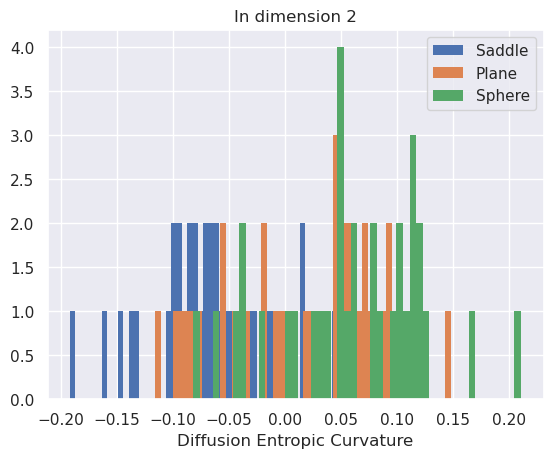

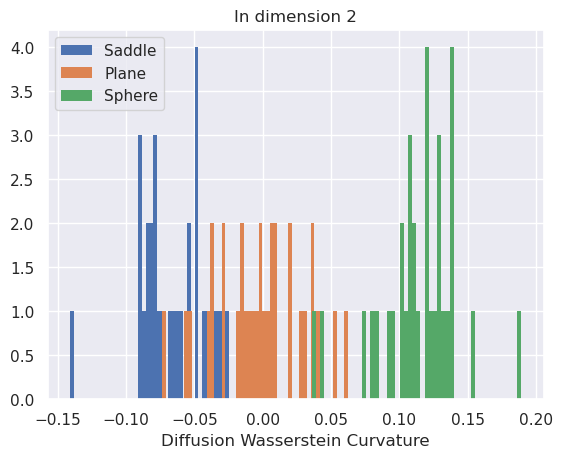

In [80]:
# globally
SS.plot()

In [14]:
SS.labels

{'ks': array([-8.,  2.,  0., -8.,  2.,  0., -8.,  2.,  0.]),
 'Diffusion Entropic Curvature': array([-0.06570292,  0.24012709, -0.4500575 ,  0.08973265,  0.24696255,
        -0.4253235 ,  0.09585857,  0.08849239, -0.49207973], dtype=float32),
 'Diffusion Wasserstein Curvature': array([0.0868578 , 0.1540178 , 0.80248463, 0.14685315, 0.204436  ,
        0.82692087, 0.05210882, 0.1994496 , 0.8144296 ], dtype=float32)}

In [42]:
SS.DS[0]

<xarray.DataArray 0 (n: 2000, d: 3)>
array([[ 0.        ,  0.        ,  0.        ],
       [ 0.03043976, -0.32589796, -0.1052829 ],
       [ 0.73380868,  0.25425393,  0.47383012],
       ...,
       [ 0.87686936, -0.60766428,  0.39964399],
       [-0.52395796,  0.64083468, -0.13613714],
       [ 0.63282661, -0.39594551,  0.24369667]])
Dimensions without coordinates: n, d
Attributes:
    ks:        -8.0
    name:      Sphere
    computed:  8

In [43]:
SS.DS.data_vars[0].attrs['name']

'Sphere'

Saddle


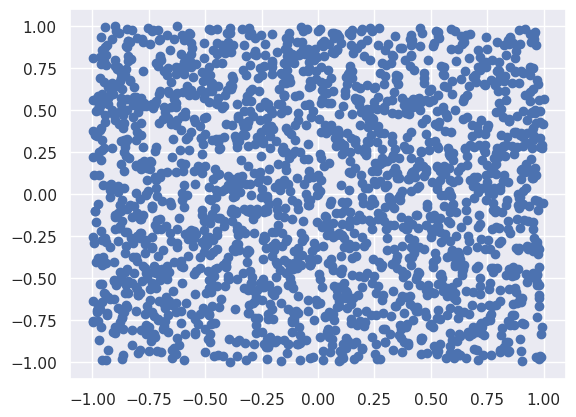

0
Sphere


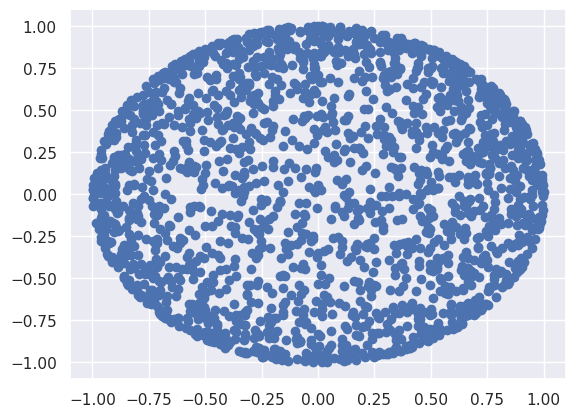

1
Plane


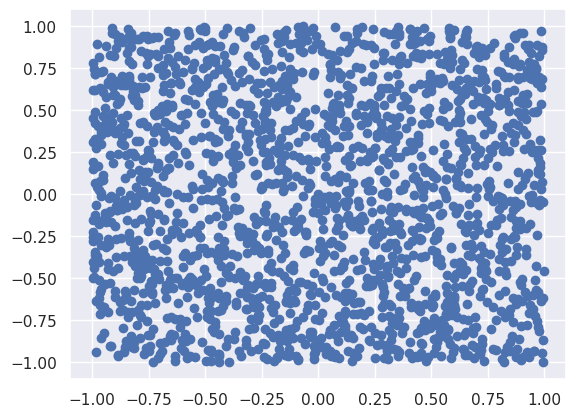

2
Saddle


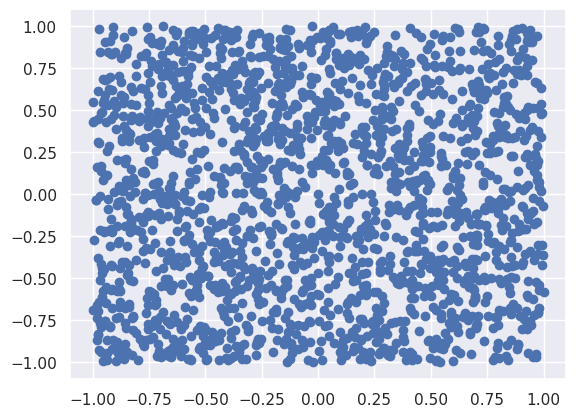

3
Sphere


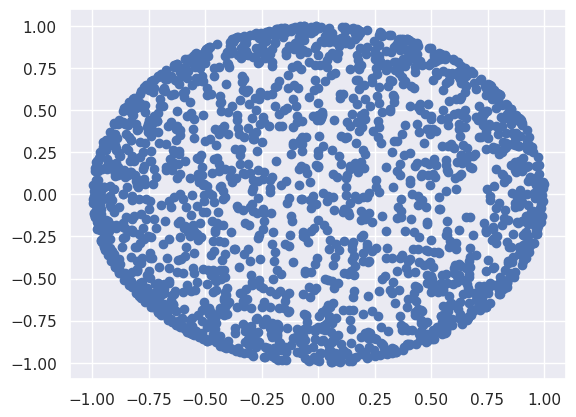

4
Plane


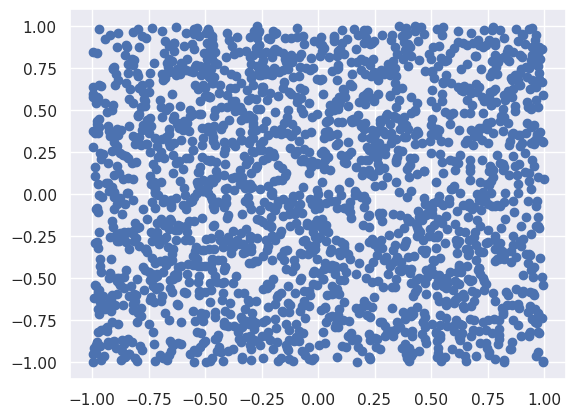

5
Saddle


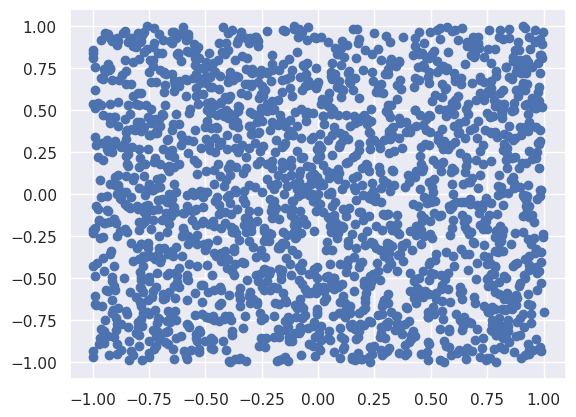

6
Sphere


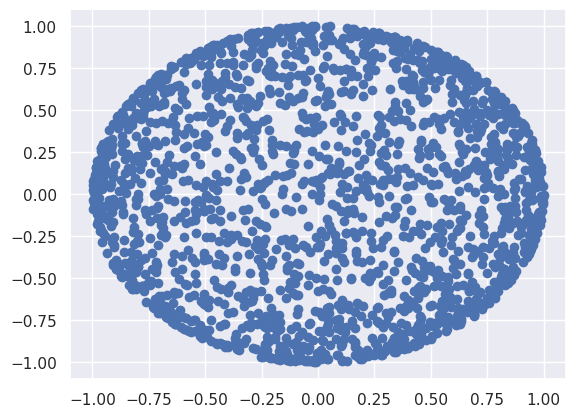

7
Plane


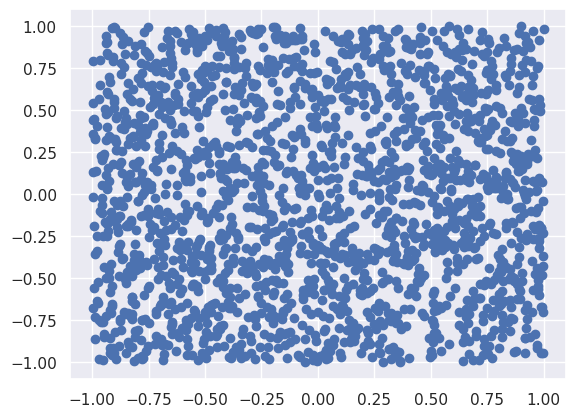

8


In [78]:
SS = SadSpheres(
    dimension = 2, # Dimension of saddles and spheres
    num_pointclouds = 10, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)
for X in SS:
    plt.scatter(X[:,0], X[:,1])
    plt.show()
    SS.update(8)
    print(SS.idx)

In [8]:
SS.compute_metrics()

In [9]:
SS.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
Diffusion Entropic Curvature,"(-0.12817516069747845, 0.742432201328523)",0.474790
Diffusion Wasserstein Curvature,"(0.41993978174865726, 0.26046359751392756)",0.136661


In [236]:
SS.mutual_info(np.ones_like(SS.labels['ks']),np.ones_like(SS.labels['ks']))

0.0

In [217]:
for name, member in inspect.getmembers(SS, predicate=inspect.ismethod):
    if hasattr(member, 'tag') and getattr(member, 'tag') == 'metric':
        print(name)

mutual_info
sign_score


In [215]:
inspect.getmembers(SS, predicate=inspect.ismethod)

[('__init__',
  <bound method SadSpheres.__init__ of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('__iter__',
  <bound method SadSpheres.__iter__ of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('__len__',
  <bound method SadSpheres.__len__ of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('__next__',
  <bound method SadSpheres.__next__ of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('_aggregate_labels',
  <bound method SadSpheres._aggregate_labels of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('_get_metrics',
  <bound method SadSpheres._get_metrics of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('compute',
  <bound method SadSpheres.compute of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('compute_metrics',
  <bound method SadSpheres.compute_metrics of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('mutual_info',
  <bound method SadSpheres.mutual_info of <__main__.SadSpheres object at 0x7b1969e186d0>>),
 ('plot',
  <bound method SadSp

In [32]:
Xplane = jnp.concatenate([jnp.zeros((1,dim)), 2*random_jnparray(num_points_in_comparison-1, dim)-1])

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_gener

NameError: name 'jnp' is not defined

In [8]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync

<IPython.core.display.Javascript object>

 WARN pixi::project::manifest: BETA feature `[pypi-dependencies]` enabled!

Please report any and all issues here:

	https://github.com/prefix-dev/pixi.

Turn this warning off by setting the environment variable `PIXI_BETA_WARNING_OFF` to `true`.

✨ Pixi task (default): nbdev_export
⠁ activating environment                                                                 